# Debug: bad chisqr

There is a population with chisqr > 100, kii = 0 and best_model = 0. 
Why is this happening?

In [1]:
import esutil
import numpy as np
import h5py
import os

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt

In [3]:
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

In [4]:
## load des deep field
des_deep_field_infile = '/data/des70.a/data/annis/StellarMass-2021/y3_deep_fields.fits'
des0 = Table(getdata(des_deep_field_infile))

## load cosmos data
cosmos_infile = '/data/des61.a/data/johnny/COSMOS/COSMOS2015_Laigle+_v1.1.fits'
cosmos0  = Table(getdata(cosmos_infile))

## load bma output
bma_out_file = '/data/des61.a/data/johnny/COSMOS/BMA/bma_test_large.fits'
bma0 = Table(getdata(bma_out_file))

In [5]:
## make a cut
mask = (bma0['zmet']<=1.)&(bma0['zmet']>=0.1)
bma = bma0[mask]

In [6]:
## match files
cosmos = cosmos0[bma['rowCOSMOS']]
des    = des0[bma['row']]

In [7]:
des['row']       = bma['row']
des['rowCOSMOS'] = bma['rowCOSMOS']

des['z_true']    = cosmos['PHOTOZ']

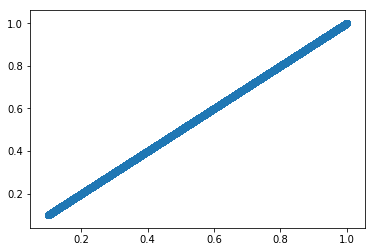

In [8]:
## check match
plt.scatter(cosmos['PHOTOZ'],bma['zmet'])

In [9]:
##drop files
cosmos0=des0=0

In [10]:
def get_log(x):
    xlog=np.log10(x)
    xlog[np.isnan(xlog)] = -99
    xlog[np.isinf(xlog)] = -99
    return xlog

def filter_nan_inf(x):
    x[np.isnan(x)] = -99
    x[np.isinf(x)] = -99
    return x

### Visualize Distributions

In [11]:
bad = bma['best_chisq']>=100
good= (bma['best_chisq']<=0.9)&(bma['best_chisq']<=1.1)

In [12]:
bma.colnames

['rowCOSMOS',
 'mass_weight_age_err',
 'gi_o',
 'index',
 'rabs',
 'gr_o_err',
 'row',
 'gi_o_err',
 'iabs',
 'mass',
 'best_chisq',
 'mass_err',
 'kii_err',
 'kri_err',
 'ssfr_std',
 'kii',
 'best_model',
 'distmod',
 'best_zmet',
 'mcMass',
 'iobs',
 'taMass',
 'mass_weight_age',
 'kri',
 'zmet',
 'gr_o',
 'ssfr',
 'iz',
 'gr',
 'redshift',
 'i',
 'ierr',
 'grerr',
 'izerr',
 'indices',
 'rierr',
 'ri']

In [13]:
def get_limits(x):
    q1,qm,q3 = np.nanpercentile(x,[25,50,75])
    iqr = q3-q1
    xlower,xupper = q1-2.*iqr,q3+2.*iqr
    xmax,xmin = np.nanpercentile(x,[99.,1.])
    xlower = np.where(xlower<xmin,xlower,xmin)
    xupper = np.where(xupper>xmax,xupper,xmax)
    return xlower,xupper

In [14]:
def plot_evolution(label):
    ymin, ymax = get_limits(bma[label])
    plt.scatter(bma['zmet'],bma[label],s=1,alpha=0.3,label='all')
    plt.scatter(bma['zmet'][good],bma[label][good],s=1,alpha=0.9,color='k',label='good')
    plt.scatter(bma['zmet'][bad],bma[label][bad],s=5,label='bad')
    
    plt.ylim(ymin,ymax)
    plt.xlim(0.,1.)
    plt.xlabel('redshift',fontsize=18)
    plt.ylabel(label,fontsize=18)
    plt.legend()

In [15]:
def plot_evolution_log(label):
    ylog = get_log(bma[label])
    ymin, ymax = get_limits(ylog)
    plt.scatter(bma['zmet'],ylog,s=1,alpha=0.3,label='all')
    plt.scatter(bma['zmet'][good],ylog[good],s=1,alpha=0.9,color='k',label='good')
    plt.scatter(bma['zmet'][bad],ylog[bad],s=5,label='bad')
    
    plt.ylim(ymin,ymax)
    plt.xlim(0.,1.)
    plt.xlabel('redshift',fontsize=18)
    plt.ylabel('log_%s'%label,fontsize=18)
    plt.legend()

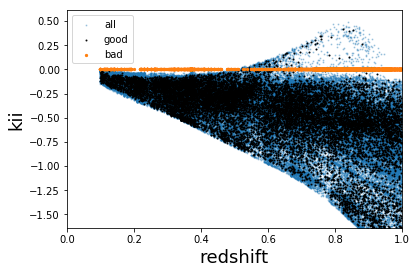

In [16]:
plot_evolution('kii')

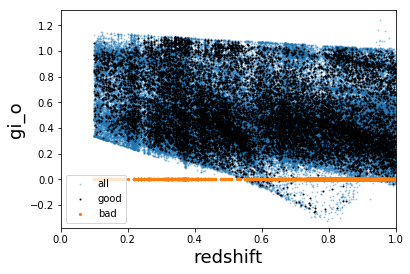

In [17]:
plot_evolution('gi_o')

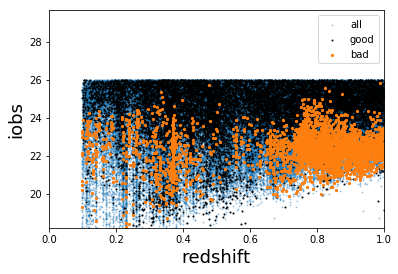

In [18]:
plot_evolution('iobs')

(-1.0, 3.0)

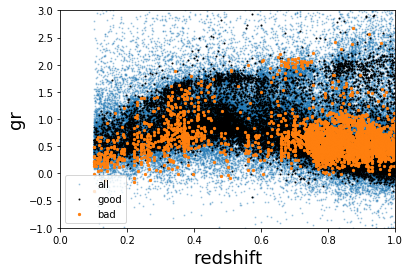

In [19]:
plot_evolution('gr')
plt.ylim(-1.,3.0)

(-1.0, 2.0)

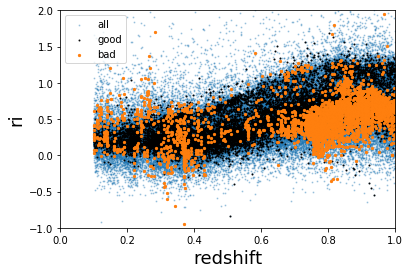

In [20]:
plot_evolution('ri')
plt.ylim(-1.,2.0)

(-1.0, 2.0)

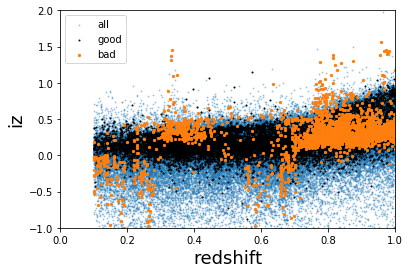

In [21]:
plot_evolution('iz')
plt.ylim(-1.,2.0)

Text(0.5,0,'Log(mag_err)')

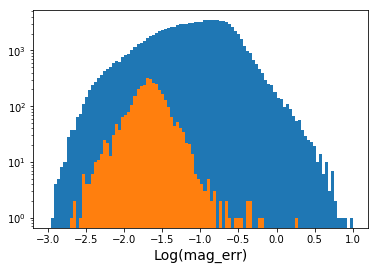

In [22]:
_ = plt.hist(get_log(bma['grerr']),bins=np.linspace(-3.,1.,101))
_ = plt.hist(get_log(bma['grerr'][bad]),bins=np.linspace(-3.,1.,101))
plt.yscale('log')
plt.xlabel('Log(mag_err)',fontsize=14)

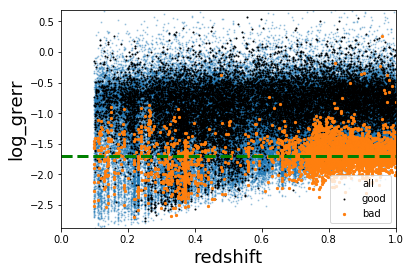

In [23]:
plot_evolution_log('grerr')
plt.axhline(np.log10(0.02),color='g',lw=3,ls='--')

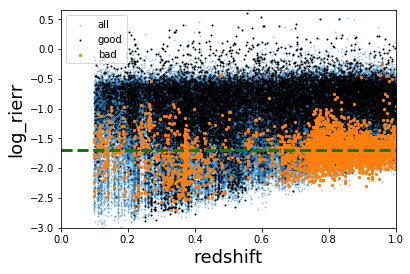

In [24]:
plot_evolution_log('rierr')
plt.axhline(np.log10(0.02),color='g',lw=3,ls='--')

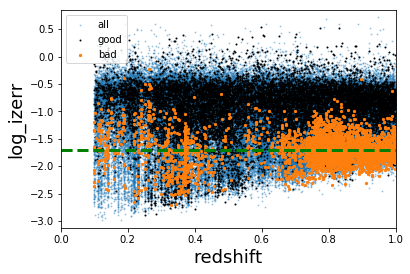

In [25]:
plot_evolution_log('izerr')
plt.axhline(np.log10(0.02),color='g',lw=3,ls='--')

The most strinking difference of the bad group is that they are cleary bright object with the lowest mag errors. While the good fits are awalys faint objeects with the highest mag errors.

### Run BMA on Bad Sample

In [ ]:
def create_input_file(files,table,nsize,nchunks):
    columns = table.keys()
    idxs    = np.linspace(0,nsize,nchunks+1,dtype=np.int64)
    
    for i,infile in enumerate(files):
        hf = h5py.File(infile,'w')
        hf.create_group('bma')
        for col in columns:
            ilo,iup = idxs[i],idxs[i+1]
            hf.create_dataset('bma/%s/'%col,data=table[col][ilo:iup])
        hf.close()

In [ ]:
def make_bma_input_temp_file(des,files,nsize,nchunks):
    out = dict()
    ## defining IDs
    out['mid']     = des['row']
    out['CID']     = des['rowCOSMOS']
    out['indices'] = np.arange(0,len(des),1,dtype=np.int64)

    out['i']    = des['MAG_I']
    out['ierr'] = des['MAGERR_I']

    out['gr']   = des['MAG_G']-des['MAG_R']
    out['ri']   = des['MAG_R']-des['MAG_I']
    out['iz']   = des['MAG_I']-des['MAG_Z']

    out['grerr']= np.sqrt(des['MAGERR_G']**2+des['MAGERR_R']**2)
    out['rierr']= np.sqrt(des['MAGERR_R']**2+des['MAGERR_I']**2)
    out['izerr']= np.sqrt(des['MAGERR_I']**2+des['MAGERR_Z']**2)

    out['redshift'] = des['z_true']
    create_input_file(files,out,nsize,nchunks)
    return out

In [ ]:
# nsize   = np.count_nonzero(bad)
# nchunks = 25

# basename  = '/data/des61.a/data/johnny/COSMOS/BMA/temp_file/bad_{}_{:03d}.hdf5'
# infiles = [basename.format('drop_floor_in',i) for i in range(nchunks)]
# outfiles= [basename.format('drop_floor_out',i) for i in range(nchunks)]

In [ ]:
# data = make_bma_input_temp_file(des[bad],infiles,nsize,nchunks)

# Running BMA

In [37]:
from joblib import Parallel, delayed
import sys

sys.path.append('/home/s1/jesteves/git/ccopa/python/bma')
import smass

def bma_trigger(infiles,outfiles,inPath,
               nCores=2,batchStart=0,batchEnd=None,overwrite=False):
    if batchEnd is None: batchEnd = self.bma_nchunks

    batches = np.arange(batchStart,batchEnd,1,dtype=np.int64)

    print('starting parallel process')
    print('nsize,nchunks,ncores:',nsize,nchunks,nCores)
    print('runing on the following batches:',batches)
    Parallel(n_jobs=nCores)(
        delayed(calc_copa_v2)(infiles[i], outfiles[i], inPath) for i in batches)
    print('ended smass calc')

In [39]:
nCores = 51
libPath= '/data/des61.a/data/pbarchi/galaxyClusters/simha_miles_Nov2016/'

# bma_trigger(infiles, outfiles, libPath,
#             nCores=nCores,batchStart=0,batchEnd=nchunks)

In [ ]:
def remove_files(files):
    for file in files:
        os.remove(file)

In [ ]:
#remove_files(infiles)

In [ ]:
remove_files(outfiles)

## LOG

<br>
<li> Errors on distanceModulus, redshift=0. </li>

In [ ]:
outfiles

# Saving as a Fits File

In [ ]:
from astropy.table import Table, vstack, join

def combine_hdf5_files(files,path='/'):
    """ Combine hdf5 files with same data structure
    """
    mylist = []
    count  = 0
    for i,file in enumerate(files):
        if os.path.isfile(file):
            mydict = read_hdf5_file_to_dict(file,path=path)
            mylist.append(mydict)
        else:
            print('missing the temp file: %s'%(file))
            count+=1

    all_dict=stack_dict(mylist)
    return all_dict, count

In [ ]:
table, nmissing = combine_hdf5_files(outfiles,path='bma/')
table2, nmissing = combine_hdf5_files(infiles,path='bma/')

t1   = Table(table)
t2   = Table(table2)
out_data = join(t1,t2,keys=['mid','CID'],join_type='inner')

out_data.rename_column('CID','rowCOSMOS')
out_data.rename_column('mid','row')

In [ ]:
out_data

In [26]:
root    = '/data/des61.a/data/johnny/COSMOS/BMA/bad/'
# outfile = root+'bma_bad_mag_error_x5.fits'
# out_data.write(outfile,format='fits',overwrite=True)

In [27]:
out_data = Table(getdata(root+'bma_bad_drop_floor.fits'))

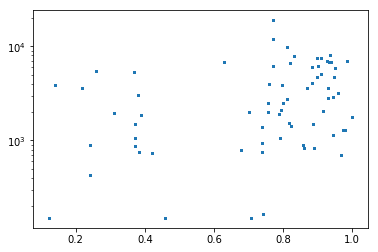

In [28]:
plt.scatter(out_data['zmet'],out_data['best_chisq'],s=1,alpha=0.3,label='all')
plt.yscale('log')

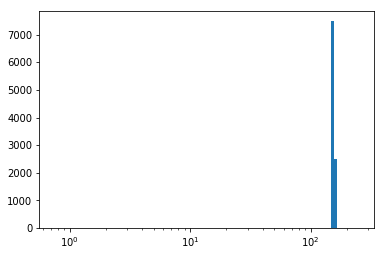

In [29]:
mybins = np.logspace(np.log10(0.75),2.4,100)
_ = plt.hist(out_data['best_chisq'],bins=mybins)
plt.xscale('log')

In [40]:
import loadPopColors

splines, zmet = loadPopColors.doAll(libPath, lib="miles")

In [41]:
dz   = 0.01
zvec = np.arange(0.1,1.+dz,dz)

In [42]:
spline_list_Dict = [get_spline(splines[sp],zmet[sp],zvec) for sp in range(len(splines))]

In [97]:
zmax,zmin = 1.,0.1
w, = np.where((zvec<=zmax)&(zvec>=zmin))

def plot_color_evolution(ax,ci,ylims=[0.,1.]):
    for i in range(len(splines)):
        ax.plot(zvec[w],spline_list_Dict[i]['s%s'%ci][w],alpha=0.9)
#     ax.scatter(bma['zmet'][good][::10],bma[ci][good][::10],color='r',s=10,alpha=0.5,zorder=100)
#     ax.scatter(out_data['zmet'],out_data[ci],color='k',s=10,alpha=0.1,zorder=100)
    ax.set_title(ci)
    ax.set_ylim(ylims[0],ylims[1])


(0.1, 1.0)

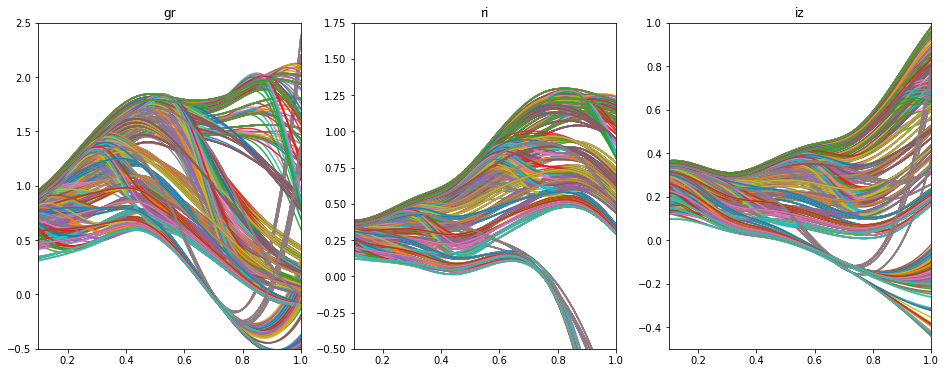

In [98]:
fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex='all')

plot_color_evolution(axis[0],'gr',ylims=[-.5,2.5])
plot_color_evolution(axis[1],'ri',ylims=[-.5,1.75])
plot_color_evolution(axis[2],'iz',ylims=[-.5,1.])
axis[0].set_xlim(zmin,zmax)
# plt.set_xlabel('redshift',fontsize=16)
# plt.set_ylabel(r'$(g-r)$',fontsize=16)


In [ ]:
# spline_list_Dict_bad  = [get_spline(splines[sp],zmet[sp],bma['zmet'][bad]) for sp in range(len(splines))]
# spline_list_Dict_good = [get_spline(splines[sp],zmet[sp],bma['zmet'][good][::4]) for sp in range(len(splines))]

In [49]:
def get_color_difference(splines_dict,data):
    dgr,dri,diz = [],[],[]
    gr = data['gr']
    ri = data['ri']
    iz = data['iz']
    z  = data['zmet']
    for i in range(len(splines)):
        sgr = np.interp(z,zvec,spline_list_Dict[i]['sgr'])
        sri = np.interp(z,zvec,spline_list_Dict[i]['sri'])
        siz = np.interp(z,zvec,spline_list_Dict[i]['siz'])
        
        dgr.append(gr - sgr)
        dri.append(ri - sri)
        diz.append(iz - siz)
    return np.array(dgr),np.array(dri),np.array(diz)

In [51]:
dgrm.shape

(1050, 3467)

In [71]:

def get_d3_min(data):
    dgrm, drim, dizm = get_color_difference(spline_list_Dict,data)
    dgm_min = np.min(np.abs(dgrm),axis=0)
    dri_min = np.min(np.abs(drim),axis=0)
    diz_min = np.min(np.abs(dizm),axis=0)
    d3_min = np.sqrt(np.min(np.abs(dgrm)**2+np.abs(drim)**2+np.abs(dizm)**2,axis=0))
    return d3_min

In [66]:
d3_good = get_d3_min(bma[good])
d3_bad  = get_d3_min(bma[bad])

(0.01, 30.50491462193283)

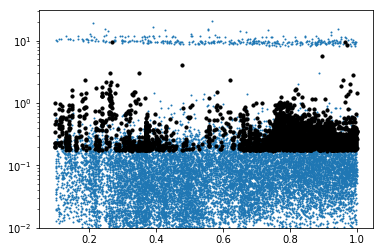

In [90]:
plt.scatter(bma['zmet'][good],np.sqrt(d3_good),s=1)
plt.scatter(bma['zmet'][bad],np.sqrt(d3_bad),s=10,color='k')
plt.yscale('log')
plt.ylim(1e-2,)

In [93]:
b3_err = np.sqrt(bma['grerr']**2+bma['izerr']**2+bma['rierr']**2)

(0.01, 86.64114863517251)

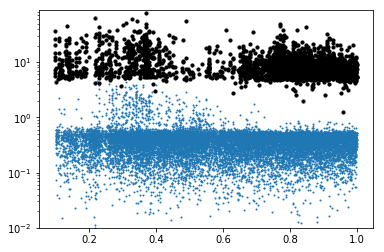

In [94]:
plt.scatter(bma['zmet'][good],np.sqrt(d3_good)/b3_err[good],s=1)
plt.scatter(bma['zmet'][bad],np.sqrt(d3_bad)/b3_err[bad],s=10,color='k')
plt.yscale('log')
plt.ylim(1e-2,)

(1e-06, 11.220184543019636)

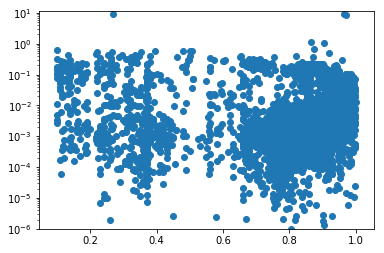

In [61]:
plt.scatter(bma['zmet'][bad],dgm_min)
plt.yscale('log')
plt.ylim(1e-,)

In [ ]:
for i in range(len(splines))[-:10]:
    plt.scatter(out_data['zmet'],vec[i])
    plt.scatter(zvec,spline_list_Dict[i]['ssfr'])

In [ ]:
np.count_nonzero(good[::4])

In [ ]:
np.count_nonzero(bad)

In [ ]:
sgr_zi = np.array([spline_list_Dict[i]['sgr'][26] for i in range(len(splines))])
sgr_zi = np.sort(sgr_zi)

In [ ]:
plt.scatter(np.diff(sgr_zi)+0.01,sgr_zi[1:])
plt.xscale('log')
plt.xlim(7e-3,1e-1)
plt.ylim(0.,2.)

In [ ]:
for i in range(len(splines)):
    plt.plot(zvec,spline_list_Dict[i]['sri'])
plt.xlabel('redshift',fontsize=16)
plt.ylabel(r'$(r-i)$',fontsize=16)
plt.title('Libray of Colors')

In [ ]:
for i in range(len(splines)):
    plt.plot(zvec,spline_list_Dict[i]['siz'])
plt.xlabel('redshift',fontsize=16)
plt.ylabel(r'$(i-z)$',fontsize=16)
plt.title('Libray of Colors')

In [ ]:
idx   = np.argsort(out_data['zmet'])
z     = out_data['zmet'][idx]
grvec = out_data['gr'][idx]
rivec = out_data['ri'][idx]
izvec = out_data['iz'][idx]

In [ ]:
np.where((z<0.38)&(z>0.36))[0][0]

In [ ]:
jj = 368
gr = grvec[jj]
ri = rivec[jj]
iz = izvec[jj]

In [ ]:
for i in range(len(splines)):
    for jj,zc in enumerate(zvec):
        sgr = spline_list_Dict[i]['sgr'][jj]
        sri = spline_list_Dict[i]['sri'][jj]
        siz = spline_list_Dict[i]['siz'][jj]
        dgr.append(gr - sgr)
        dri.append(ri - sri)
        diz.append(iz - siz)
    spline_list_Dict[i]['dgr'] = dgr

In [ ]:
dgr

In [ ]:
len(zmet)

In [ ]:
np.nanmin(out_data['best_chisq'])

In [ ]:
plt.scatter(t1['zmet'],t1['gi_o'],s=1,alpha=0.3,label='all')

In [ ]:
plt.hist(t1['best_chisq'],bins=21)
plt.xscale('log')

In [ ]:
masst= cosmos['MASS_BEST'][bad]
mass = t1['mass']

In [ ]:
plt.scatter(masst,mass)

In [ ]:
log_residual = mass-masst

In [ ]:
np.std(log_residual)

In [ ]:
indices = esutil.numpy_util.match(out_data['row'],des['row'])

In [ ]:
#indices = out_data['index']
descut  = des[indices[1]]
cosmocut= cosmo[indices[1]]

In [ ]:
np.count_nonzero(descut['row']-out_data['row'][indices[0]])

In [ ]:
plt.scatter(descut['row'],out_data['row'])

In [ ]:
plt.scatter(cosmocut['row'],out_data['rowCOSMOS'])

In [ ]:
rabs  = out_data['rabs']
rabst = cosmocut['MR']

masst = descut['smass']
mass  = out_data['mass']

log_residual = filter_nan_inf(mass-masst)#get_log(residual)
residual     = 10**log_residual

zt    = descut['z_true']
z     = out_data['best_zmet']

model = out_data['best_model']
chisq = out_data['best_chisq']

In [ ]:
plt.scatter(masst,mass,s=10,alpha=0.2)
plt.plot([6,14],[6,14],'k--')
plt.xlim(6.,14)
plt.ylim(6.,14)
plt.ylabel('mass_BMA')
plt.xlabel('mass_COSMOS')

In [ ]:
_ = plt.hist(log_residual,bins=np.linspace(-3.,3.,101))
plt.xlabel('log_residual (mass)')

In [ ]:
idx = np.argsort(-1*chisq)
plt.scatter(masst[idx],log_residual[idx],s=5,alpha=0.8,c=np.log10(chisq)[idx],cmap='Dark2')
plt.plot([6.,12.],[0,0],'k--')
plt.xlim(6.,12.)
plt.ylim(-4,4)
plt.xlabel('mass_COSMOS')
plt.ylabel('log_residual (mass)')
plt.colorbar()

In [ ]:
idx = np.argsort(model)
plt.scatter(masst[idx],log_residual[idx],s=5,alpha=0.8,c=model[idx],cmap='Dark2')
plt.plot([6.,12.],[0,0],'k--')
plt.xlim(6.,12.)
plt.ylim(-4,4)
plt.xlabel('mass_COSMOS')
plt.ylabel('log_residual (mass)')
plt.colorbar()

In [ ]:
plt.scatter(zt,log_residual,s=10,alpha=0.2)
plt.plot([0,4.],[0,0],'k--')
plt.xlim(0.,4.)
plt.ylim(-4,4)
plt.xlabel('z')
plt.ylabel('log_residual (mass)')

In [ ]:
plt.scatter(rabst,rabs,s=10,alpha=0.2)
plt.plot([-27.,-10.],[-27.,-10.],'k--')
plt.xlim(-27,-10.)
plt.ylim(-27,-10.)
# plt.xlabel('z')
# plt.ylabel('log_residual (mass)')

In [ ]:
cut = mass<5

In [ ]:
mass[cut]

# Prepare input files

# Auxialiary Functions

In [ ]:
def check_not_hf5(hf,path):
    return path not in hf.keys()

def delete_group(fname,path):
    fmaster = h5py.File(fname,'a')
    try:
        group   = fmaster[path]
    except:
        fmaster.close()
        return

    cols = group.keys()
    if len(cols)>0:
        for col in cols: del group[col]
    fmaster.close()
    
def stack_dict(in_list):
    columns = list(in_list[0].keys())
    new_dict= dict().fromkeys(columns)
    for col in columns:
        res = [mydict[col] for mydict in in_list]
        new_dict[col] = np.concatenate(res)
    return new_dict

def read_hdf5_file_to_dict(file,cols=None,indices=None,path='/'):
    hf = h5py.File(file, 'r')
    
    mygroup = hf[path]

    if cols is None: cols  = list(mygroup.keys())
    if indices is None: indices = np.arange(0,len(mygroup[cols[0]]),1,dtype=np.int64)

    mydict= dict().fromkeys(cols)
    for col in cols:
        mydict[col] = mygroup[col][:][indices]
    
    hf.close()

    return mydict


# Visualizing the input sample

In [ ]:
data

In [ ]:
plt.scatter(data['z_true'],data['i'],s=10,alpha=0.1)

In [35]:
import numpy as np
import h5py

#import helperfunctions
#import weightedstats as ws
#import pyfits as pf
from astropy.io import fits as pf
#
# inputDataDict is what holds the input photometry
# it expects ids, i, ierr, gr,ri,iz, grerr, rierr, izerr
#
#

#### Johnny at 27 october 2019.
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(H0=70, Om0=0.286)

def luminosityDistance(z):
    DL = float( cosmo.luminosity_distance(z) / u.Mpc ) # em Mpc
    return DL

def _get_spline(spline,zmet,zed):
    # for speed
    sgr  = float(spline[0](zed))
    sri  = float(spline[1](zed))
    siz  = float(spline[2](zed))
    sgrr = float(spline[4](zed)) ;# restframe g-r
    sgir = float(spline[5](zed)) ;# restframe g-i
    skii = float(spline[6](zed)) ;# kcorrection: i_o - i_obs
    skri = float(spline[7](zed)) ;# kcorrection: r_o - i_obs
    sml  = float(spline[8](zed)) ;# log(mass/light)  (M_sun/L_sun)
    ssfr = float(spline[9](zed))
    if (ssfr<-20.): ssfr=-20.
    sage_cosmic = float(spline[10](zed))
    sage = float(spline[11](zed))
    szmet = float(zmet)
    return np.array([sgr,sri,siz,sgrr,sgir,skii,skri,sml,ssfr,sage,szmet])

def get_spline(spline,zmet,allzed):
    unique_zed, index_zed = np.unique(allzed,return_inverse=True)
    nsize = unique_zed.size
    toto = np.zeros((nsize,11),dtype=np.float64)

    for i,zed in enumerate(unique_zed):
        toto[i] = _get_spline(spline,zmet,zed)
    
    cols  = ['sgr','sri','siz','sgrr','sgir','skii','skri','sml','ssfr','sage','szmet']
    res   = dict().fromkeys(cols)
    for i,col in enumerate(cols):
        arr = np.array(toto[:,i])
        res[col] = arr[index_zed]
    return res

def calc_copa_v2(infile, outfile, indir="simha/", lib="miles"):
    # import CosmologicalDistance
    from scipy.stats import chi2
    import os
    import logging
    import loadPopColors

    inputDataDict = load_input(infile)

    logging.debug('Starting smass.calc()')

    # cd = CosmologicalDistance.CosmologicalDistance(omega_m=0.286,omega_l=0.714)
    ldistDict = dict()
    #splineDict = dict()

    splines, zmet = loadPopColors.doAll(indir, lib=lib)
    index = inputDataDict["indices"]
    ids  = inputDataDict["mid"]
    haloid  = inputDataDict["CID"]
    mi  = inputDataDict["i"]
    ierr  = inputDataDict["ierr"]
    gr  = inputDataDict["gr"]
    ri  = inputDataDict["ri"]
    iz  = inputDataDict["iz"]
    grerr  = inputDataDict["grerr"]
    rierr  = inputDataDict["rierr"]
    izerr  = inputDataDict["izerr"]
    allzed = inputDataDict["redshift"]

    factor =2
    grerr *=factor
    rierr *=factor
    izerr *=factor
    print 'factor: ', factor
    
    #print zmet
    # protect against too small of errors => values = 0
    ix = np.nonzero(grerr < 0.02)[0]
    grerr[ix] = 0.02
    print 'fraction of small errors: gr', 1.*ix.size/ri.size

    ix = np.nonzero(rierr < 0.02)[0]
    rierr[ix] = 0.02
    print 'fraction of small errors: ri', 1.*ix.size/ri.size

    ix = np.nonzero(izerr < 0.02)[0]
    izerr[ix] = 0.02
    print 'fraction of small errors: iz', 1.*ix.size/ri.size
    print '\n'
    
    # prepping for output
    nvariables = 27
    out_index, out_id, out_haloid, out_gr, out_stdgr, out_gi, out_stdgi, \
    out_kri, out_stdkri, out_kii, out_stdkii, out_iobs, out_distmod, \
    out_bestzmet,out_stdzmet, out_rabs, out_iabs, out_mass_gr, out_mass_gi, out_mass, out_stdmass, out_sfr, out_stdsfr, out_age, out_stdage, \
    out_zmet, out_zed = [[] for i in range(nvariables)]
    
    out_bestsp, out_bestchisq = [], []

    size = haloid.size
    
    ## splines for a given cluster redshift
    spline_list_Dict = [get_spline(splines[sp],zmet[sp],allzed) for sp in range(len(splines))]

    #size = 10
    for galaxy in range(0,size) :
        zed = allzed[galaxy]

        logging.debug('{i} of {len}, z = {z}'.format(
            i = galaxy+1, len = size, z = zed))

        rest_gr,rest_gi,weight,chisqs = [], [],[],[]
        masslight, sfrs,ages, zmets,kii, kri = [],[],[],[],[],[]
        minChiSq = 999; spIndex = -1
        for sp in range(len(splines)):
            splineDict = spline_list_Dict[sp]
            #To be changed if SFH changes
            #splineDict[skey] = sgr,sri,siz,sgrr,sgir,skii,skri,sml
            sgr  = splineDict['sgr'][galaxy]
            sri  = splineDict['sri'][galaxy] 
            siz  = splineDict['siz'][galaxy]
            sgrr = splineDict['sgrr'][galaxy];  # restframe g-r
            sgir = splineDict['sgir'][galaxy];  # restframe g-i
            skii = splineDict['skii'][galaxy];  # kcorrection: i_o - i_obs
            skri = splineDict['skri'][galaxy];  # kcorrection: r_o - i_obs
            sml  = splineDict['sml'][galaxy];   # log(mass/light)  (M_sun/L_sun)
            ssfr = splineDict['ssfr'][galaxy]
            sage = splineDict['sage'][galaxy]
            szmet= splineDict['szmet'][galaxy]

            gre = grerr[galaxy]
            rie = rierr[galaxy]
            ize = izerr[galaxy]
            gr_chisq = pow((gr[galaxy] - sgr)/gre,2)
            ri_chisq = pow((ri[galaxy] - sri)/rie,2)
            iz_chisq = pow((iz[galaxy] - siz)/ize,2)
            rest_gr.append(sgrr)
            rest_gi.append(sgir)
            kii.append(skii)
            kri.append(skri)
            masslight.append(sml)
            sfrs.append(ssfr)
            ages.append(sage)
            zmets.append(szmet)
            chisq = gr_chisq + ri_chisq + iz_chisq
            probability = 1-chi2.cdf(chisq, 3-1) ;# probability of chisq greater than this
            
            weight.append(probability)
            chisqs.append(chisq)
        spIndex = np.argmax(weight)
        rest_gr = np.array(rest_gr)
        rest_gi = np.array(rest_gi)
        kii = np.array(kii)
        kri = np.array(kri)
        masslight = np.array(masslight)
        sfrs = np.array(sfrs)
        idx_sfr = (sfrs<-8.)
        ages = np.array(ages)
        weight = np.array(weight)
        gr_weighted = rest_gr * weight
        gi_weighted = rest_gi * weight
        kii_weighted = kii * weight
        kri_weighted = kri * weight
        #weight_norm = weight/np.sum(weight)
        masslight_weighted = masslight * weight
        sfr_weighted = 10**sfrs[idx_sfr] * weight[idx_sfr]
        age_weighted = ages * weight
        zmet_weighted = zmets * weight
        w1 = weight.sum()
        w2 = (weight**2).sum()
        if w1 == 0 : w1 = 1e-10
        if w2 == 0 : w2 = 1e-10
        mean_gr  = gr_weighted.sum()/w1
        mean_gi  = gi_weighted.sum()/w1
        mean_kii = kii_weighted.sum()/w1
        mean_kri = kri_weighted.sum()/w1
        mean_masslight = masslight_weighted.sum()/w1
        #try :
        #    if weight.shape[0]>1.:
        #        mean_sfr = float(ws.numpy_weighted_median(sfrs, weights=weight)) #np.median(sfr_weighted) #sfr_weighted.sum()/w1
        #    else:weight
        #        mean_sfr = -70.
        #except :
        #    mean_sfr = -70.
        #print mean_sfr
        mean_age = age_weighted.sum()/w1
        mean_zmet = zmet_weighted.sum()/w1
        mean_sfr = sfr_weighted.sum()/w1
        # unbiased weighted estimator of the sample variance
        w3 = w1**2 - w2
        if w3 == 0 : w3 = 1e-10
        var_gr = ( w1/w3 ) * (weight*(rest_gr - mean_gr)**2).sum()
        var_gi = ( w1/w3 ) * (weight*(rest_gi - mean_gi)**2).sum()
        var_kii = ( w1/w3 ) * (weight*(kii - mean_kii)**2).sum()
        var_kri = ( w1/w3 ) * (weight*(kri - mean_kii)**2).sum()
        var_masslight = ( w1/w3 ) * (weight*(masslight - mean_masslight)**2).sum()
        var_sfr = ( w1/w3 ) * (weight*(sfrs - mean_sfr)**2).sum()
        var_age = ( w1/w3 ) * (weight*(ages - mean_age)**2).sum()
        var_zmet = ( w1/w3 ) * (weight*(zmets - mean_zmet)**2).sum()
        std_gr = var_gr**0.5
        std_gi = var_gi**0.5
        std_kii = var_kii**0.5
        std_kri = var_kri**0.5
        std_masslight = var_masslight**0.5
        std_sfr = var_sfr**0.5
        std_age = var_age**0.5
        std_zmet = var_zmet**0.5 
        if std_gr > 99.99 : std_gr = 99.99
        if std_gi > 99.99 : std_gi = 99.99
        if std_kii > 99.99 : std_kii = 99.99
        if std_kri > 99.99 : std_kri = 99.99
        if std_sfr > 99.99 : std_sfr = 99.99
        if std_age > 99.99 : std_age = 99.99
        if std_masslight > 99.99 : std_masslight = 99.99
        if std_zmet > 99.99 : std_zmet = 99.99
        # Comment -distanceModulus out for fsps versions <2.5, as their mags don't include distance modulus
        if zed in ldistDict :
            lumdist = ldistDict[zed]
        else :
            # lumdist = cd.luminosity_distance(zed) ;# in Mpc
            lumdist = luminosityDistance(zed)
            ldistDict[zed] = lumdist
            
        distanceModulus = 5*np.log10(lumdist*1e6/10.)
        iabs = mi[galaxy] + mean_kii - distanceModulus
        rabs = mi[galaxy] + mean_kri - distanceModulus
        taMass = taylorMass(mean_gi, iabs)
        mcMass = mcintoshMass(mean_gr, rabs)
        fsMass = fspsMass( mean_masslight, iabs )
        # JTA: to make purely distance modulus
        #iabs = i[galaxy] - distanceModulus 
        #fsMass = gstarMass( iabs )
        if i+2<=size:
            myidx = np.argsort(-1*weight)
            print 'probs, chisq', weight[myidx], np.array(chisqs)[myidx]

        # saving for output
        out_index.append( index[galaxy])
        out_id.append( ids[galaxy] )
        out_haloid.append( haloid[galaxy] )
        out_gr.append( mean_gr )
        out_stdgr.append(std_gr )
        out_gi.append( mean_gi )
        out_stdgi.append( std_gi)
        out_kii.append( mean_kii )
        out_stdkii.append( std_kii )
        out_kri.append( mean_kri )
        out_stdkri .append( std_kri )
        out_iobs.append( mi[galaxy] )
        out_distmod.append( distanceModulus )
        out_iabs.append( iabs )
        out_rabs.append( rabs )
        out_mass_gr.append( mcMass )
        out_mass_gi.append( taMass )
        out_mass.append( fsMass )
        out_stdmass.append( std_masslight )
        out_bestsp.append( spIndex )
        out_bestzmet.append( zmets[spIndex] )
        out_bestchisq.append(chisqs[spIndex])
        out_sfr.append( mean_sfr )
        out_stdsfr.append( std_sfr  )
        out_age.append( mean_age )
        out_stdage.append( std_age  )
        out_zmet.append( mean_zmet )
        out_stdzmet.append( std_zmet  )
        out_zed.append( allzed[galaxy] )
    
    out_index = np.array(out_index).astype(int)
    out_id = np.array(out_id)#.astype(int)
    out_haloid = np.array(out_haloid).astype(int)
    out_gr = np.array(out_gr)
    out_stdgr = np.array(out_stdgr)
    out_gi = np.array(out_gi)
    out_stdgi = np.array(out_stdgi)
    out_kii = np.array(out_kii)
    out_stdkii = np.array(out_stdkii)
    out_kri = np.array(out_kri)
    out_stdkri  = np.array(out_stdkri )
    out_iobs = np.array(out_iobs)
    out_distmod = np.array(out_distmod)
    out_iabs = np.array(out_iabs)
    out_rabs = np.array(out_rabs)
    out_mass_gr = np.array(out_mass_gr)
    out_mass_gi = np.array(out_mass_gi)
    out_mass = np.array(out_mass)
    out_stdmass = np.array(out_stdmass)
    out_sfr = np.array(out_sfr)
    out_stdsfr = np.array(out_stdsfr)
    out_age = np.array(out_age)
    out_stdage = np.array(out_stdage)
    out_bestsp = np.array(out_bestsp)
    out_zmet = np.array(out_zmet)
    out_bestzmet = np.array(out_bestzmet)
    out_zed =np.array(out_zed)
    out_bestchisq = np.array(out_bestchisq)

    columns = ['index','mid','CID','gr_o','gr_o_err','gi_o','gi_o_err','kii','kii_err','kri','kri_err','iobs',
                'distmod','iabs','rabs','mcMass','taMass','mass','mass_err','ssfr','ssfr_std','mass_weight_age','mass_weight_age_err',
                'best_model','best_zmet','zmet','best_chisq']

    vectors = [out_index,out_id,out_haloid,out_gr,out_stdgr,out_gi,out_stdgi,out_kii,out_stdkii,out_kri,out_stdkri,out_iobs,
               out_distmod,out_iabs,out_rabs,out_mass_gr,out_mass_gi,out_mass,out_stdmass,out_sfr,out_stdsfr,out_age,out_stdage,
               out_bestsp,out_bestzmet,out_zed,out_bestchisq]

    mydict = dict().fromkeys(columns)
    for col,arr in zip(columns,vectors):
        mydict[col] = arr
    
    write_hdf5_file(outfile,mydict,columns)

    logging.debug('Returning from smass.calc()')


def load_input(fname):
    fmaster = h5py.File(fname, 'r')
    columns = list(fmaster['bma'].keys())

    mydict = dict().fromkeys(columns)
    for col in columns:
        mydict[col] = fmaster['bma/%s/'%col][:]
    return mydict

def write_hdf5_file(fname,table,columns):
    fmaster = h5py.File(fname, 'w')
    if check_not_hf5(fmaster,'bma'): fmaster.create_group('bma')
    for col in columns:
        fmaster.create_dataset('bma/%s/'%col, data= table[col][:])
    fmaster.close()

def check_not_hf5(hf,path):
    return path not in hf.keys()
#### end Johnny

def mcintoshMass (gr, rabs, h=0.7) :
    # equation 1, McIntosh et al 2014, arXiv:1308.0054v2
    mass = -0.406 + 1.097*gr - 0.4*(rabs - 5*np.log10(h) - 4.64)
    # log(mass/h^2) 
    return mass

def taylorMass (gi, iabs) :
    mass = -0.68 + 0.70*gi - 0.4*(iabs - 4.58)
    # assumes h=0.7
    return mass

def fspsMass( masstolight , iabs) :
    # following the above, which assumes h=0.7
    mass =  masstolight - 0.4*(iabs - 4.58)
    return mass
# how far off is just distance modulus?
def gstarMass(iabs) :
    mass =  - 0.4*(iabs - 4.58)
    return mass


528.5714285714286

# Removing temp files

In [ ]:
def remove_files(files):
    for file in files:
        os.remove(file)

In [ ]:
#remove_files(bma_temp_input_files)
#remove_files(bma_temp_output_files)